In [4]:
import torch
from torch import nn

import torch.functional as F
import torchvision.transforms.functional as TF
import torch.utils.checkpoint as checkpoint

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import numpy as np
import random

import models
import utils

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

1f41e
1f98b


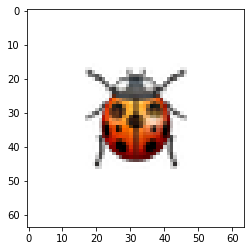

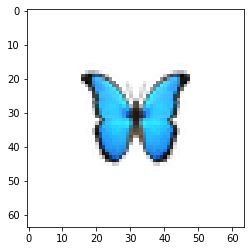

In [5]:
image_1 = utils.load_emoji("🐞",32,16).to(device)
image_2 = utils.load_emoji("🦋",32,16).to(device)

plt.imshow(image_1.transpose(0,2).cpu())
plt.show()
plt.imshow(image_2.transpose(0,2).cpu())
plt.show()

img_size = 64

In [13]:
n_channels = 16
n_epochs = 5000
lr = 0.001
pool_size = 1024
batch_size = 16
hidden_size = 128

images = torch.stack([image_1,image_2])

model = models.Automata((64, 64), n_channels, hidden_size, device).cuda()

# initialize pool with seeds
seed = torch.zeros(n_channels,img_size,img_size).cuda()
seed[3:,32,32] = 1

seed_1 = seed.clone()
seed_2 = seed.clone()

seed_1[4,32,32] = 0

seeds = torch.stack([seed_1,seed_2])

pool_initials = seeds.repeat(pool_size//2,1,1,1)
pool_targets = images.repeat(pool_size//2,1,1,1)

pool_target_ids = torch.Tensor([0,1]).repeat(pool_size//2).long()
# 0 for image_1, 1 for image_2
# half image 1, half image 2

losses = []

criterion = nn.MSELoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for i in range(n_epochs):
    
    iterations = random.randint(96,128)

    pool_indices = torch.Tensor(random.sample(range(pool_size),batch_size)).long()
        
    initial_states = pool_initials[pool_indices]
    targets = pool_targets[pool_indices]
    target_ids = pool_target_ids[pool_indices]

    out = model(initial_states,iterations)
    
    phenotypes = out[:,:4].squeeze()

    optimizer.zero_grad()

    loss = criterion(phenotypes, targets)
    
    per_sample_loss = loss.mean((1,2,3))
    total_loss = per_sample_loss.mean()

    total_loss.backward()
    optimizer.step()
    
    # argsort the losses per sample
    ranked_loss = per_sample_loss.argsort()
    
    # get indices of min- and max-loss samples
    min_loss_indices = ranked_loss[:1]
    max_loss_indices = ranked_loss[1:]
    
    replacements = out.detach()
    
    max_loss_targets = target_ids[max_loss_indices]
    
    # high-loss outputs are re-tasked with
    # mapping the seeds to the respective image
    
    # low-loss outputs are tasked with mapping
    # the previous output to the same image
    
    replacements[max_loss_indices] = seeds[max_loss_targets]
    pool_initials[pool_indices] = replacements
    
    if i % 100 == 0:
    
        print(i, np.log10(float(total_loss.cpu().detach())))
        
        torch.save(model.state_dict(), "../models/divergence_"+str(i))
        
        
    losses.append(float(total_loss))

0 -1.2855725111323113
100 -1.7307308473371592
200 -1.9973122393999005
300 -2.1588391816223256
400 -2.1899740655846163
500 -2.211937356775728
600 -2.2954139493808356
700 -2.3185952159439873
800 -2.357725557611709
900 -2.2987069775267694
1000 -2.391926669311505
1100 -2.369288577183044
1200 -2.583061034229215
1300 -2.6446614700311737
1400 -2.427554263056825
1500 -2.7298570084720017
1600 -2.770641262626792
1700 -2.7916538360820464
1800 -2.792428341531285
1900 -2.891789543209304
2000 -2.839721213295708
2100 -2.8304668424421378
2200 -2.8304840889216365
2300 -2.901630340062828
2400 -2.936843187072506
2500 -2.8091863589443884
2600 -2.9182704064988054
2700 -2.9767941714729367
2800 -2.9944958639937505
2900 -2.9517484826438487
3000 -3.090730785165815
3100 -2.8433013919511936
3200 -3.116527487510366
3300 -3.0916764875790355
3400 -3.1466998037916776
3500 -3.2012111932632803
3600 -3.0108420881885296
3700 -3.289884649911129
3800 -3.254386370019564
3900 -3.343511218740818
4000 -3.336911016672337
4100 

In [17]:
import time

time.sleep(5000)

for i in range(5000,15000):
    
    iterations = random.randint(96,128)

    pool_indices = torch.Tensor(random.sample(range(pool_size),batch_size)).long()
        
    initial_states = pool_initials[pool_indices]
    targets = pool_targets[pool_indices]
    target_ids = pool_target_ids[pool_indices]

    out = model(initial_states,iterations)
    
    phenotypes = out[:,:4].squeeze()

    optimizer.zero_grad()

    loss = criterion(phenotypes, targets)
    
    per_sample_loss = loss.mean((1,2,3))
    total_loss = per_sample_loss.mean()

    total_loss.backward()
    optimizer.step()
    
    # argsort the losses per sample
    ranked_loss = per_sample_loss.argsort()
    
    # get indices of min- and max-loss samples
    min_loss_indices = ranked_loss[:1]
    max_loss_indices = ranked_loss[1:]
    
    replacements = out.detach()
    
    max_loss_targets = target_ids[max_loss_indices]
    
    # high-loss outputs are re-tasked with
    # mapping the seeds to the respective image
    
    # low-loss outputs are tasked with mapping
    # the previous output to the same image
    
    replacements[max_loss_indices] = seeds[max_loss_targets]
    pool_initials[pool_indices] = replacements
    
    if i % 100 == 0:
    
        print(i, np.log10(float(total_loss.cpu().detach())))
        
        torch.save(model.state_dict(), "../models/divergence_"+str(i))
        
        
    losses.append(float(total_loss))

5000 -3.411262641693222
5100 -3.592362366431213
5200 -3.579017388054555
5300 -3.609519728156548
5400 -3.523621052338785
5500 -3.559423787907957
5600 -3.393197329469753
5700 -3.6142887689322394
5800 -3.5706888566984385
5900 -3.6022325612507693
6000 -3.6658653112143194
6100 -3.7634240951131583
6200 -3.769126781840387
6300 -3.588505018039134
6400 -3.658026110930629
6500 -3.8448647038974313
6600 -3.722726176979749
6700 -3.804196397183804
6800 -3.73620202210406
6900 -3.258914743430954
7000 -3.8152082873640003
7100 -3.844870805603859
7200 -3.8018839672047253
7300 -3.950633509279573
7400 -3.889619457349744
7500 -4.004291603639029
7600 -3.9972065861615436
7700 -3.827397159608495
7800 -3.9923720997428043
7900 -3.919175250425659
8000 -3.9917608662479287
8100 -3.9460923202743485
8200 -3.614878277826719
8300 -3.933121268525764
8400 -4.009629471342588
8500 -4.006911046432455
8600 -3.9545637870113057
8700 -4.0805425469906424
8800 -4.13722560475745
8900 -4.08616480660992
9000 -4.002564343383717
9100 

In [19]:
model.load_state_dict(torch.load("../models/divergence_10600"))


<All keys matched successfully>

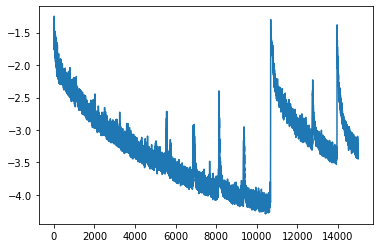

In [20]:
plt.plot(np.log10(losses))

In [23]:
seed_3 = seed.clone()
seed_3[4,32,32] = 0.5

In [24]:
with torch.no_grad():
    out = model(seed_3[None,:],1024,keep_history=True)
    video = model.history.cpu().detach()
    video = video[:,0,:4]
    video = video.transpose(1,3)

from matplotlib import animation
from IPython.display import HTML

fig = plt.figure()
im = plt.imshow(video[0,:,:,:])

plt.close()

def init():
    im.set_data(video[0,:,:,:])

def animate(i):
    im.set_data(video[i,:,:,:])
    return im

anim = animation.FuncAnimation(fig, animate, init_func=init,  frames=video.shape[0],
                               interval=50)
HTML(anim.to_html5_video())

/home/khu/anaconda3/envs/cenv/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
